# Section 1: The Dataset

Throughout my time at University, I've had the pleasure of becoming friends with a wide range of people. These friends have given me lifelong memories and have shaped the way I think about communication. While thinking of what project I should do, I remembered a conversation I had with a friend a couple of years ago. My friend has autism, and he was lamenting over how he struggles to identify emotions. What many people find intuitive is a cruel and frustrating challenge to him, one he says separates him from others. I wanted to make a project that could help those who struggle to understand emotions so that they could feel more included and less isolated from their peers. That's when I came across "boltuix/emotions-dataset" on HuggingFace (https://huggingface.co/datasets/boltuix/emotions-dataset). I looked over the dataset and thought it would be perfect for this project.

With this dataset, I'll be creating two pipelines that categorize a sentence into one of 13 emotions. The dataset has 131,306 total rows with two features, "Sentence" and "Label", where "Sentence" is the text that's being classified, and "Label" is the emotion of that text.

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

/Users/daniel/Documents/Projects/Python/Natural-Language-Processing/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

print("Downloading dataset...")
dataset = load_dataset("boltuix/emotions-dataset", split='train')
df = dataset.to_pandas()

df = df.groupby("Label").filter(lambda x: len(x) >= 10000)
df = pd.concat([df[df["Label"] == "happiness"].sample(n=17000, random_state=0), df[df["Label"] != "happiness"]], ignore_index=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
print("FIRST 5 ROWS:")
print(df.head())

print("\nDATASET INFORMATION:")
print(df.info())

print("\nLABEL DISTRIBUTION:")
print(df["Label"].value_counts())

FIRST 5 ROWS:
                                            Sentence      Label
0  Yes . It will be fun . Driving back down the c...  happiness
1  im feeling more comfortable with derby i feel ...  happiness
2  know feel today part convince make much diffic...  happiness
3  His work schedule is pretty consistent so I sh...  happiness
4                         Thank you for your service  happiness

DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74395 entries, 0 to 74394
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  74395 non-null  object
 1   Label     74395 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None

LABEL DISTRIBUTION:
Label
sadness      17809
happiness    17000
neutral      15733
anger        13341
love         10512
Name: count, dtype: int64


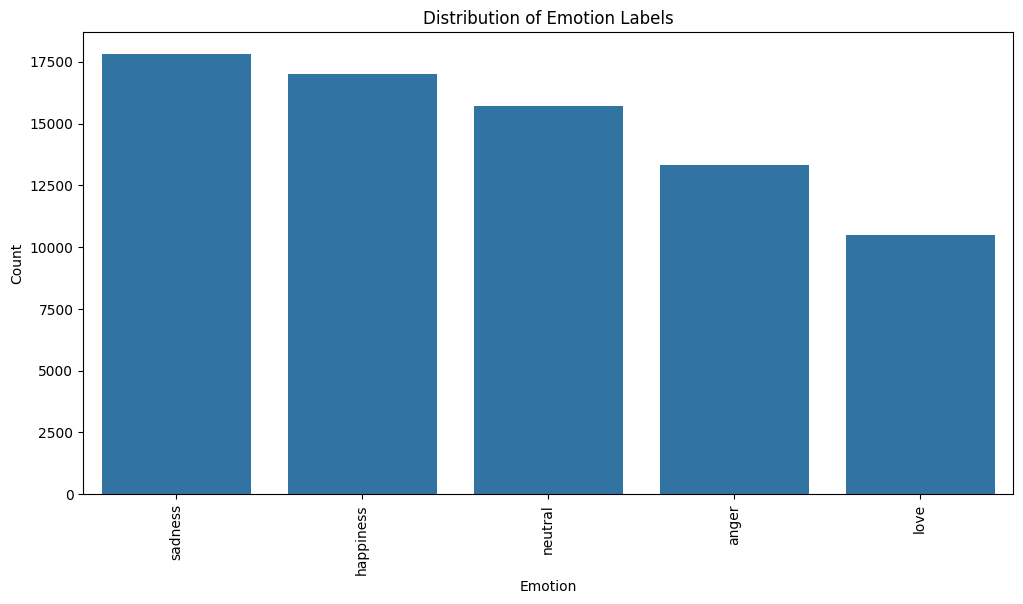

In [4]:
plt.figure(figsize=(12, 6))

sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)

plt.xticks(rotation=90)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence, flags=re.I|re.A)

    tokens = sentence.split(" ")
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words:
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned_tokens)

df["Cleaned_Sentence"] = df["Sentence"].apply(preprocess_sentence)

print("ORIGINAL FIRST SENTENCE:")
print(df["Sentence"].iloc[0])

print("\nCLEANED FIRST SENTENCE:")
print(df["Cleaned_Sentence"].iloc[0])

ORIGINAL FIRST SENTENCE:
Yes . It will be fun . Driving back down the coast . My girlfriend will like it .

CLEANED FIRST SENTENCE:
yes  fun  driving back coast  girlfriend like 


In [6]:
x = df["Cleaned_Sentence"]
y = df["Label"]

# Test size was 0.2, but the accuracy was 50% and 58% respectively. After experimenting with it, 0.1 seems like a good split for the highest accuracy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
print("Total samples: {}".format(len(x)))
print("Training samples: {}".format(len(x_train)))
print("Testing samples: {}".format(len(x_test)))

Total samples: 74395
Training samples: 66955
Testing samples: 7440


# Section 2: Representation Learning

The algorithms I used require numerical input. Therefore, the text must be vectorized. For this, I used Term Frequency–Inverse Document Frequency (TF-IDF).

TF-IDF is a combination of "Term Frequency" and "Inverse Document Frequency". Term Frequency is how often a word occurs in a document/sentence. For example, in the sentence "I feel happy, so happy", "happy" scores two and all the other words score one. The issue is many unhelpful words like "a" or "the" score high despite their unhelpfulness. The Inverse Document Frequency helps solve this.

Inverse Document Frequency (IDF) is how rare a word is across the dataset. The idea behind it is that common words don't help us classify sentences, but rarer words do.

Combining TF and IDF, you can identify the most important words. This reduces the weight of common words. For example, a word may be common in our dataset, but it doesn't help us classify the sentence. Just using Term Frequency, that word could get a high score, making it seem important. Using IDF with TF gives that word a low score, reducing that word's influence over the classification.

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

print("SHAPE OF NEW VECTORS:")
print("Training vectors shape: {}".format(x_train_tfidf.shape))
print("Test vectors shape: {}".format(x_test_tfidf.shape))

SHAPE OF NEW VECTORS:
Training vectors shape: (66955, 5000)
Test vectors shape: (7440, 5000)


# Section 3: Algorithms

For this project, I decided to compare Naive Bayes and Logistic Regression. I felt these would be good as Naive Bayes is a probabilistic model and Logistic Regression is a linear one. A probabilistic model is simply one that outputs probabilities, rather than giving a specific answer. It allows you to see how certain a prediction is, and how confident that model is compared to other possible predictions it could have made. On the other hand, a linear model makes its predictions based off the sum of its input, with those inputs potentially having a different weight.

## Naive Bayes

The first model I chose was Multinomial Naive Bayes, which is based off Bayes’ Theorem. Naive Bayes works off predicting the probability of a value based off previous probabilities. Essentially, it calculates the probability a word appears in a certain class. In this case, while the model is training, it calculates the probability of each word appearing in each class. For example, it might calculate that the word "awesome" has a 20% chance of appearing in a happy sentence, whereas it only has a 0.5% chance of appearing in a sad sentence. Now when classifying a sentence, it goes through the emotions and multiplies the probabilities that each of the words in the sentence would appear in that emotion's class. It then just picks the emotion with the highest percentage.

The reason it's called "Naive Bayes" is because it makes a "naive" assumption about how language works. It assumes that each word doesn't affect other words in context. For example, in the sentence "I'm not happy", the "not" inverts the meaning of the sentence, turning a happy person into a sad person. Naive Bayes doesn't take that into consideration. It takes each word on its own, without knowledge of how it affects the meaning of the words around it. Even with this issue however, Naive Bayes does perform surprisingly well for text-based classification.

I decided to use Multinomial Naive Bayes because it's specifically for counts or frequencies. Other forms like Gaussian work better with more continuous forms of data.

## Logistic Regression

The other model I chose is Logistic Regression. It's a linear model that works off learning weights for every word in the TF-IDF vectoriser. For example, it may figure out that "happy" heavily indicates that a sentence is happy, therefore it gives "happy" a heavy weighting towards happiness. Now anytime it sees "happy" in a sentence, it takes that weighting and uses it (and the weights of the other words in the sentence) to classify the sentence. It's essentially being pulled to different emotions by each of the words in that sentence, and whichever word/words pull hardest win. It's important to note however, just because a word has a heavy weighting, it doens't mean that many lighter-weighted words can't "overpower" that word.

To make the final classification, the model uses a "softmax function". This just takes the weights and converts them into probabilities, (i.e, 80% happy, 15% excited, 5% angry), and whichever emotion has the highest probability is selected. This is quite different from Naive Bayes, as Naive Bayes assumes the words are independent from each other, whereas Logistic Regression uses a combination of weights to find the best decision boundary to separate each emotion.

In [8]:
nb_model = MultinomialNB()

print("Training the naive bayes model...")
nb_model.fit(x_train_tfidf, y_train)
print("Training complete!")

Training the naive bayes model...
Training complete!


In [9]:
lr_model = LogisticRegression(max_iter=500, random_state=0)

print("Training the logistic regression model...")
lr_model.fit(x_train_tfidf, y_train)
print("Training complete!")

Training the logistic regression model...
Training complete!


# Section 4: Evaluation

In [10]:
y_pred = nb_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy: {}".format(accuracy))

label_names = df["Label"].unique()
label_names.sort()

report = classification_report(y_test, y_pred, target_names=label_names)
print(report)

Naive Bayes Accuracy: 0.6446236559139785
              precision    recall  f1-score   support

       anger       0.74      0.57      0.65      1334
   happiness       0.61      0.67      0.64      1700
        love       0.77      0.43      0.55      1051
     neutral       0.54      0.66      0.59      1574
     sadness       0.69      0.78      0.73      1781

    accuracy                           0.64      7440
   macro avg       0.67      0.62      0.63      7440
weighted avg       0.66      0.64      0.64      7440



NAIVE BAYES CONFUSION MATRIX:


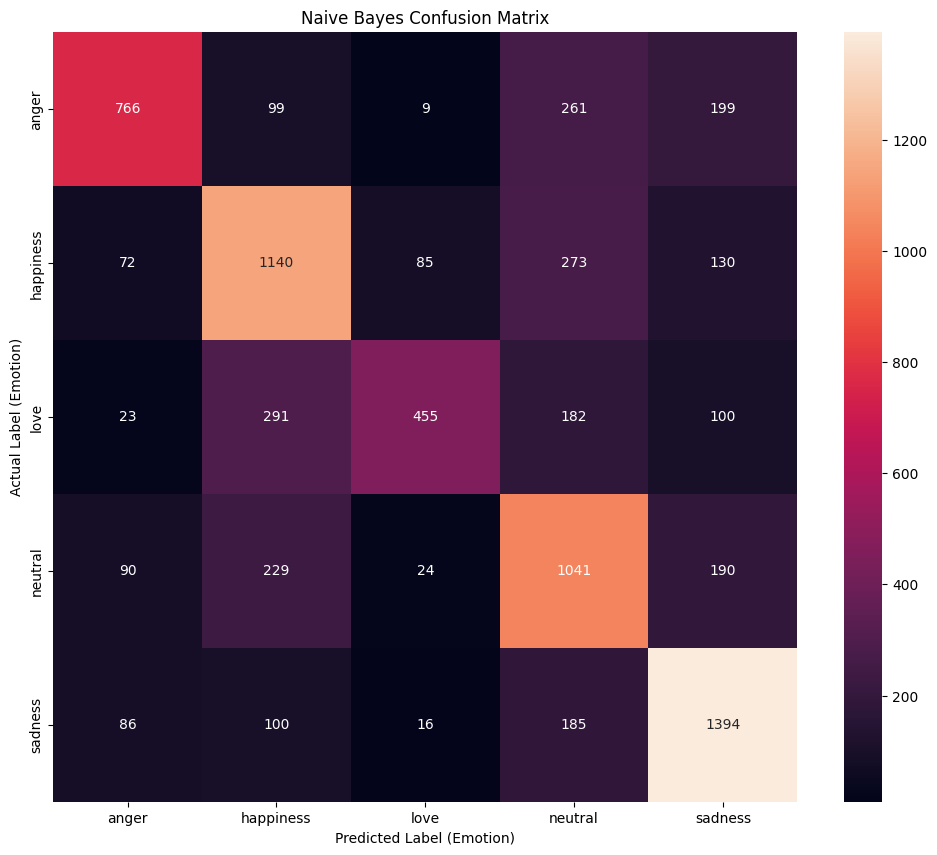

In [11]:
print("NAIVE BAYES CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

plt.xlabel('Predicted Label (Emotion)')
plt.ylabel('Actual Label (Emotion)')
plt.title("Naive Bayes Confusion Matrix")

plt.show()

In [12]:
print("TOP 10 WORDS FOR EACH EMOTION (NAIVE BAYES):")

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
class_labels = nb_model.classes_
for i, label in enumerate(class_labels):
    
    top10_indices = np.argsort(nb_model.feature_log_prob_[i])[-10:]
    top_features = feature_names[top10_indices]
    
    print(label + ": ", end="")
    print(", ".join(top_features))
    print("")

TOP 10 WORDS FOR EACH EMOTION (NAIVE BAYES):
anger: fucking, im, people, get, hate, feeling, fuck, name, like, feel

happiness: make, good, happy, thank, lol, thanks, feeling, im, like, feel

love: get, thats, one, really, im, great, good, like, feel, love

neutral: know, would, people, thats, one, think, im, get, dont, like

sadness: name, get, know, really, sad, sorry, im, feeling, like, feel



In [13]:
y_pred_lr = lr_model.predict(x_test_tfidf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy: {}".format(accuracy_lr))

report_lr = classification_report(y_test, y_pred_lr, target_names=label_names)
print(report_lr)

Logistical Regression Accuracy: 0.7103494623655914
              precision    recall  f1-score   support

       anger       0.74      0.64      0.69      1334
   happiness       0.72      0.66      0.69      1700
        love       0.72      0.63      0.67      1051
     neutral       0.60      0.80      0.69      1574
     sadness       0.81      0.78      0.79      1781

    accuracy                           0.71      7440
   macro avg       0.72      0.70      0.71      7440
weighted avg       0.72      0.71      0.71      7440




LOGISTICAL REGRESSION CONFUSION MATRIX:


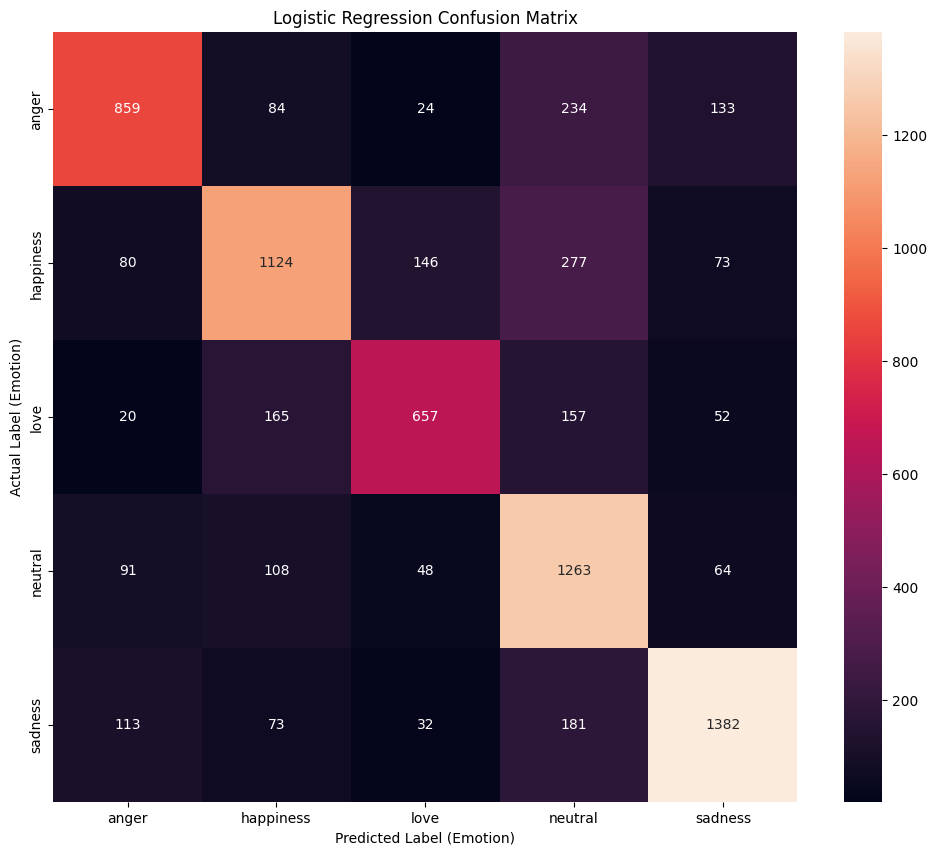

In [14]:
print("\nLOGISTIC REGRESSION CONFUSION MATRIX:")
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)

plt.xlabel('Predicted Label (Emotion)')
plt.ylabel('Actual Label (Emotion)')
plt.title('Logistic Regression Confusion Matrix')

plt.show()

In [15]:
print("TOP 10 WORDS FOR EACH EMOTION (LOGISTIC REGRESSION):")

for i, label in enumerate(class_labels):
    top10_indices = np.argsort(lr_model.coef_[i])[-10:]
    top_features = feature_names[top10_indices]
    
    print(label + ": ", end="")
    print(", ".join(top_features))
    print("")

TOP 10 WORDS FOR EACH EMOTION (Logistic Regression):
anger: rude, envious, bitchy, greedy, frustration, angry, resentful, rebellious, irritable, fuck

happiness: delighted, fun, ecstatic, happy, haha, glad, thank, thanks, lol, feel

love: gentle, naughty, delicate, loyal, great, fond, tender, nostalgic, sympathetic, love

neutral: theyll, afternoon, regular, wasnt, dont, shouldnt, isnt, doesnt, there, breeze

sadness: vain, unimportant, sorrow, unfortunate, lethargic, sadly, sorry, melancholy, sad, feel

